In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from matplotlib.font_manager import FontProperties, fontManager
import pandas as pd
import kagglehub
import datetime

# 创建必要的目录
required_dirs = ['img', 'csv', 'datasets']
for dir_name in required_dirs:
    os.makedirs(dir_name, exist_ok=True)

# 1.数据集获取

本项目使用的蘑菇图像数据集托管在 [Kaggle](https://www.kaggle.com/) 平台上，数据集名称为 [huizecai/mushroom](https://www.kaggle.com/datasets/huizecai/mushroom)。
该数据集包含了多种常见蘑菇的高清图片，以及对应的分类标签。

为了方便数据获取，我们使用 `kagglehub` 库来自动下载和管理数据集。
下面的代码会直接从 Kaggle 下载数据集，并返回保存在本地的路径。
数据集下载完成后会被缓存，后续运行时将直接使用缓存版本，无需重复下载。

In [32]:
# 设置数据集名称
dataset_name = "huizecai/mushroom"  # 指定要下载的Kaggle数据集名称

# 使用KaggleHub下载数据集
path = kagglehub.dataset_download(dataset_name)  # 下载数据集并获取保存路径

# 打印数据集文件的保存路径
print("Path to dataset files:", path)

# 设置数据和标签文件的具体路径
dataset_path = path + '/archive/data'  # 图片数据所在目录的路径
label_path = path + '/archive/label.txt'  # 标签文件的路径

Path to dataset files: /kaggle/input/mushroom


# 2.数据集类别统计分析

为了避免TensorFlow处理中文路径时可能出现的编码问题，本数据集采用了规范化的命名方式:
 - 各蘑菇种类的文件夹以"classXX"格式命名(XX为数字编号)
 - 使用label.txt文件建立文件夹编号与中文名称的映射关系
 - 这种设计既保证了系统兼容性，又方便了数据的管理和使用

In [45]:
# 获取所有子目录（即蘑菇类别）
dir_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 读取 label.txt 并解析内容
categories = {}  # 创建一个空字典用于存储类别ID和名称的映射关系
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            category_name = parts[0]  # 第一部分为类别名称(中文)
            category_id = parts[1]    # 第二部分为类别ID
            categories[category_id] = category_name  # 建立ID到名称的映射

# 统计每种类别的图像数量
category_counts = {}  # 创建空字典存储每个类别的图片数量
for category_id in categories.keys():
    if category_id in dir_names:
        category_dir = os.path.join(dataset_path, category_id)
        num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
        category_counts[categories[category_id]] = num_images

# 打印每个类别的图片数量统计结果
print("Categories:", categories)
print("Category counts:", category_counts)

# 保存类别统计结果到CSV文件
category_df = pd.DataFrame(list(category_counts.items()), columns=['蘑菇种类', '图片数量'])
category_df.to_csv('csv/category_counts.csv', index=False, encoding='utf-8-sig')

Categories: {'class00': '羊肚菌', 'class01': '牛肝菌', 'class02': '鸡油菌', 'class03': '鸡枞菌', 'class04': '青头菌', 'class05': '奶浆菌', 'class06': '干巴菌', 'class07': '虎掌菌', 'class08': '白葱牛肝菌', 'class09': '老人头菌', 'class10': '猪肚菌', 'class11': '谷熟菌', 'class12': '白参菌', 'class13': '黑木耳', 'class14': '银耳', 'class15': '金耳', 'class16': '猴头菇', 'class17': '香菇', 'class18': '平菇', 'class19': '金针菇', 'class20': '口蘑', 'class21': '鹿茸菇', 'class22': '榆黄蘑', 'class23': '榛蘑', 'class24': '草菇', 'class25': '鸡腿菇', 'class26': '茶树菇', 'class27': '蟹味菇', 'class28': '白玉菇', 'class29': '红菇', 'class30': '杏鲍菇', 'class31': '松茸', 'class32': '姬松茸', 'class33': '松露', 'class34': '竹荪', 'class35': '虫草花'}
Category counts: {'羊肚菌': 170, '牛肝菌': 155, '鸡油菌': 153, '鸡枞菌': 165, '青头菌': 174, '奶浆菌': 182, '干巴菌': 156, '虎掌菌': 177, '白葱牛肝菌': 181, '老人头菌': 137, '猪肚菌': 109, '谷熟菌': 160, '白参菌': 171, '黑木耳': 174, '银耳': 127, '金耳': 157, '猴头菇': 176, '香菇': 168, '平菇': 161, '金针菇': 115, '口蘑': 139, '鹿茸菇': 154, '榆黄蘑': 177, '榛蘑': 172, '草菇': 149, '鸡腿菇': 137, '茶树菇': 159, '蟹味菇': 10

# 3.解决matplotlib中文显示问题

matplotlib默认不支持中文字体显示,可能会出现乱码。为了确保数据可视化结果能正确展示中文:
1. 我们将下载并使用"SimHei"(黑体)字体
2. 注册字体到matplotlib的字体管理器
3. 配置全局字体设置

这样可以保证后续所有图表中的中文标题、标签等都能正常显示。

In [34]:
# 设置字体文件的URL和本地保存路径
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"
font_name = "SimHei.ttf"

# 如果字体文件不存在则下载
if not os.path.exists(font_name):
    response = requests.get(font_url)
    if response.status_code == 200:
        with open(font_name, 'wb') as f:
            f.write(response.content)
    else:
        print(f"下载字体文件失败,状态码: {response.status_code}")

# 配置matplotlib的字体设置
fontManager.addfont(font_name)
font_prop = FontProperties(fname=font_name)

# 设置全局字体配置
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600

# 4.绘制各种类图片数量的柱状图

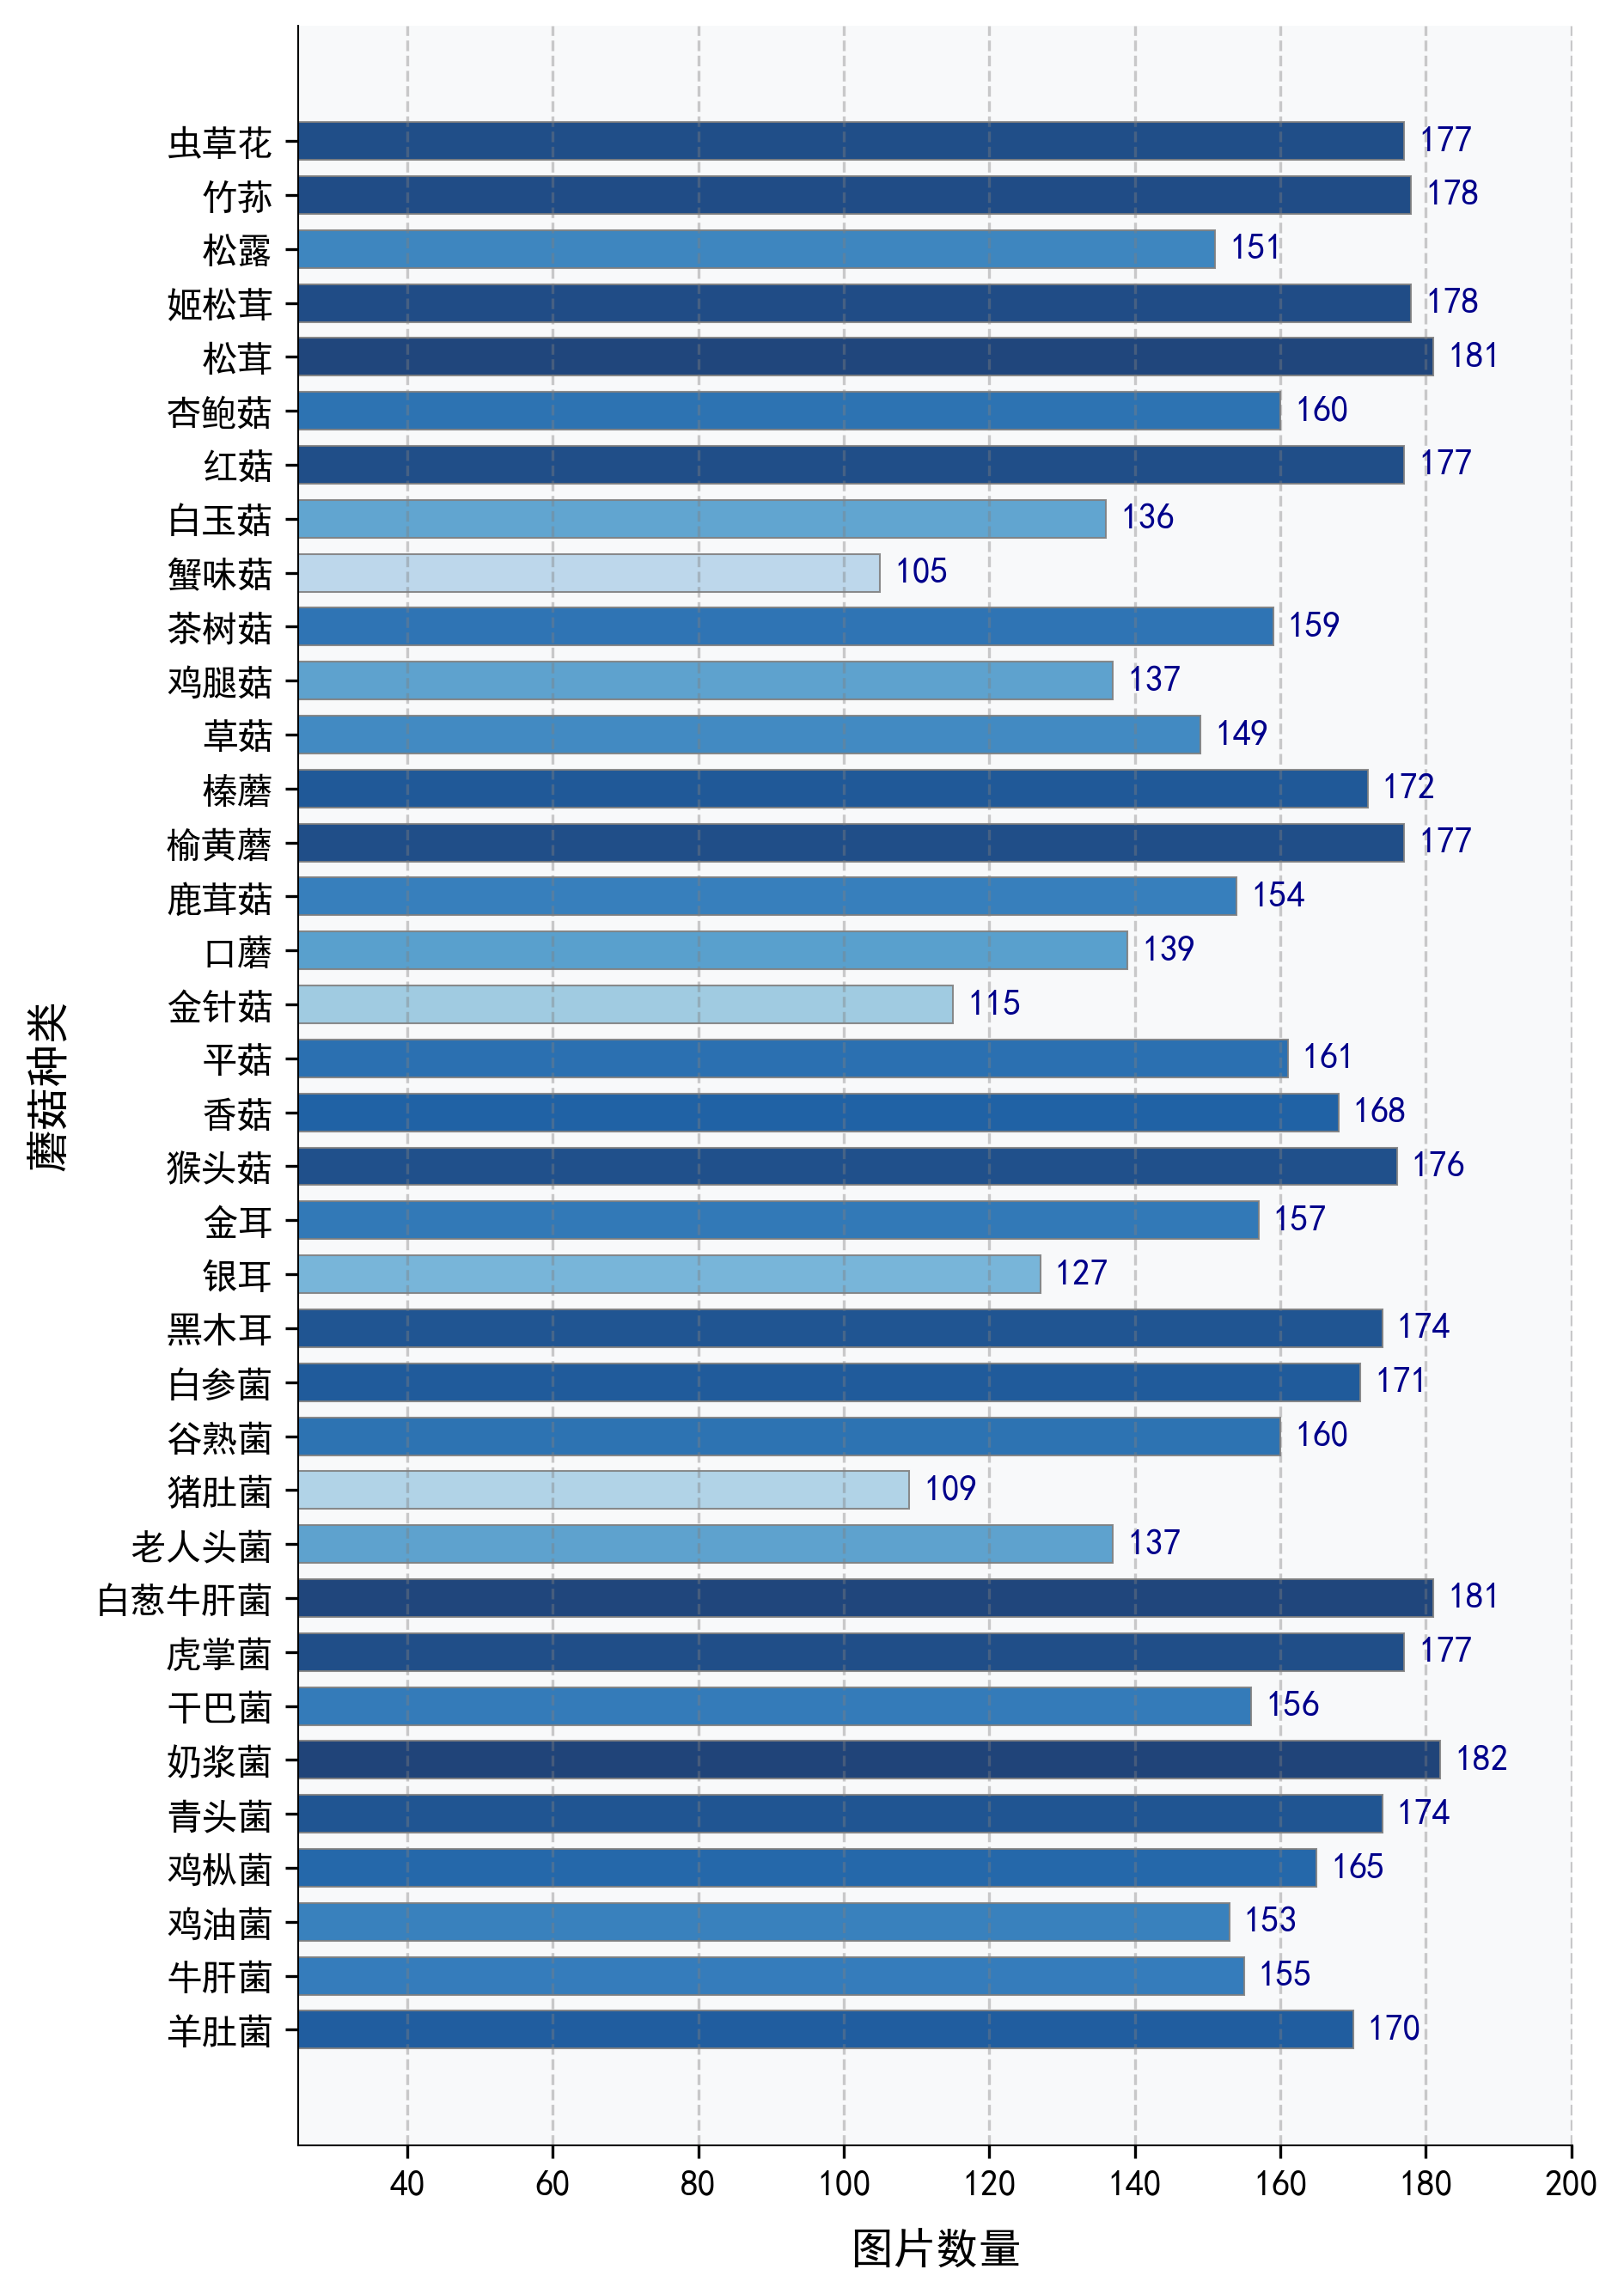

In [35]:
# 准备数据
categories_readable = list(category_counts.keys())
counts = list(category_counts.values())

# 创建一个新的图形
plt.figure(figsize=(6.4, 9))

# 创建颜色渐变
count_category_pairs = list(zip(counts, categories_readable))
count_category_pairs.sort(key=lambda x: x[0])
sorted_categories = [pair[1] for pair in count_category_pairs]
sorted_counts = [pair[0] for pair in count_category_pairs]

# 创建颜色映射
norm = plt.Normalize(min(counts), max(counts))
colors = plt.cm.Blues(norm(counts) * 0.7 + 0.3)

# 绘制水平柱状图
bars = plt.barh(categories_readable, counts, color=colors, height=0.7,
                edgecolor='gray', linewidth=0.5, alpha=0.9)

# 添加数值标签
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             va='center', ha='left', fontsize=10, fontweight='bold',
             color='darkblue')

# 设置图表标题和轴标签
plt.xlabel('图片数量', fontsize=12, labelpad=8)
plt.ylabel('蘑菇种类', fontsize=12, labelpad=8)

# 设置坐标轴样式
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlim(25, max(counts) + max(counts)*0.1)

# 添加网格线
plt.grid(axis='x', linestyle='--', alpha=0.4, color='gray')

# 添加背景色
plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)

# 自动调整布局
plt.tight_layout()

# 保存图表
plt.savefig('img/mushroom_distribution.png',
            bbox_inches='tight',
            dpi=800,
            facecolor='#f8f9fa')

# 显示图形
plt.show()

# 5.加载图像数据集

使用 TensorFlow 的 image_dataset_from_directory 函数加载和准备图像数据集：
- directory=dataset_path ：指定图像数据所在的路径
- image_size=(224, 224) ：指定每个图像的大小为224x224像素
- batch_size=32 ：指定每个批次包含32张图像
- validation_split=0.2 ：指定20%的数据作为验证集
- subset='both' ：指定同时返回训练集和验证集
- label_mode='categorical' ：指定标签模式为分类模式，返回one-hot编码的标签
- seed=66 ：设置随机种子以确保数据集的可重复性

In [36]:
# 加载和准备图像数据集
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset='both',
    label_mode='categorical',
    seed=66
)

Found 5698 files belonging to 36 classes.
Using 4559 files for training.
Using 1139 files for validation.


# 6.计算训练集和验证集中各类别图像的分布情况

统计训练集和验证集中每个蘑菇类别的图像数量，以便了解数据集的分布特征。

In [37]:
# 获取类别名称
class_names = train_dataset.class_names

# 初始化字典用于存储每种类别的图像数量
train_category_counts = {name: 0 for name in categories.values()}
validation_category_counts = {name: 0 for name in categories.values()}

# 统计训练集中的图像数量
for images, labels in train_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        train_category_counts[categories[category_name]] += 1

# 统计验证集中的图像数量
for images, labels in validation_dataset:
    for label in labels.numpy():
        category_name = class_names[np.argmax(label)]
        validation_category_counts[categories[category_name]] += 1

# 打印统计结果
print("训练集类别图像数量统计:", train_category_counts)
print("验证集类别图像数量统计:", validation_category_counts)

# 保存训练集和验证集统计结果到CSV文件
train_val_df = pd.DataFrame({
    '蘑菇种类': list(train_category_counts.keys()),
    '训练集数量': list(train_category_counts.values()),
    '验证集数量': list(validation_category_counts.values())
})
train_val_df.to_csv('csv/train_val_counts.csv', index=False, encoding='utf-8-sig')

训练集类别图像数量统计: {'羊肚菌': 129, '牛肝菌': 126, '鸡油菌': 117, '鸡枞菌': 139, '青头菌': 139, '奶浆菌': 144, '干巴菌': 113, '虎掌菌': 132, '白葱牛肝菌': 156, '老人头菌': 108, '猪肚菌': 88, '谷熟菌': 125, '白参菌': 139, '黑木耳': 140, '银耳': 103, '金耳': 122, '猴头菇': 142, '香菇': 128, '平菇': 127, '金针菇': 92, '口蘑': 117, '鹿茸菇': 123, '榆黄蘑': 146, '榛蘑': 133, '草菇': 119, '鸡腿菇': 112, '茶树菇': 128, '蟹味菇': 88, '白玉菇': 112, '红菇': 143, '杏鲍菇': 121, '松茸': 153, '姬松茸': 148, '松露': 115, '竹荪': 147, '虫草花': 145}
验证集类别图像数量统计: {'羊肚菌': 41, '牛肝菌': 29, '鸡油菌': 36, '鸡枞菌': 26, '青头菌': 35, '奶浆菌': 38, '干巴菌': 43, '虎掌菌': 45, '白葱牛肝菌': 25, '老人头菌': 29, '猪肚菌': 21, '谷熟菌': 35, '白参菌': 32, '黑木耳': 34, '银耳': 24, '金耳': 35, '猴头菇': 34, '香菇': 40, '平菇': 34, '金针菇': 23, '口蘑': 22, '鹿茸菇': 31, '榆黄蘑': 31, '榛蘑': 39, '草菇': 30, '鸡腿菇': 25, '茶树菇': 31, '蟹味菇': 17, '白玉菇': 24, '红菇': 34, '杏鲍菇': 39, '松茸': 28, '姬松茸': 30, '松露': 36, '竹荪': 31, '虫草花': 32}


# 7.绘制训练集和验证集图片数量对比图

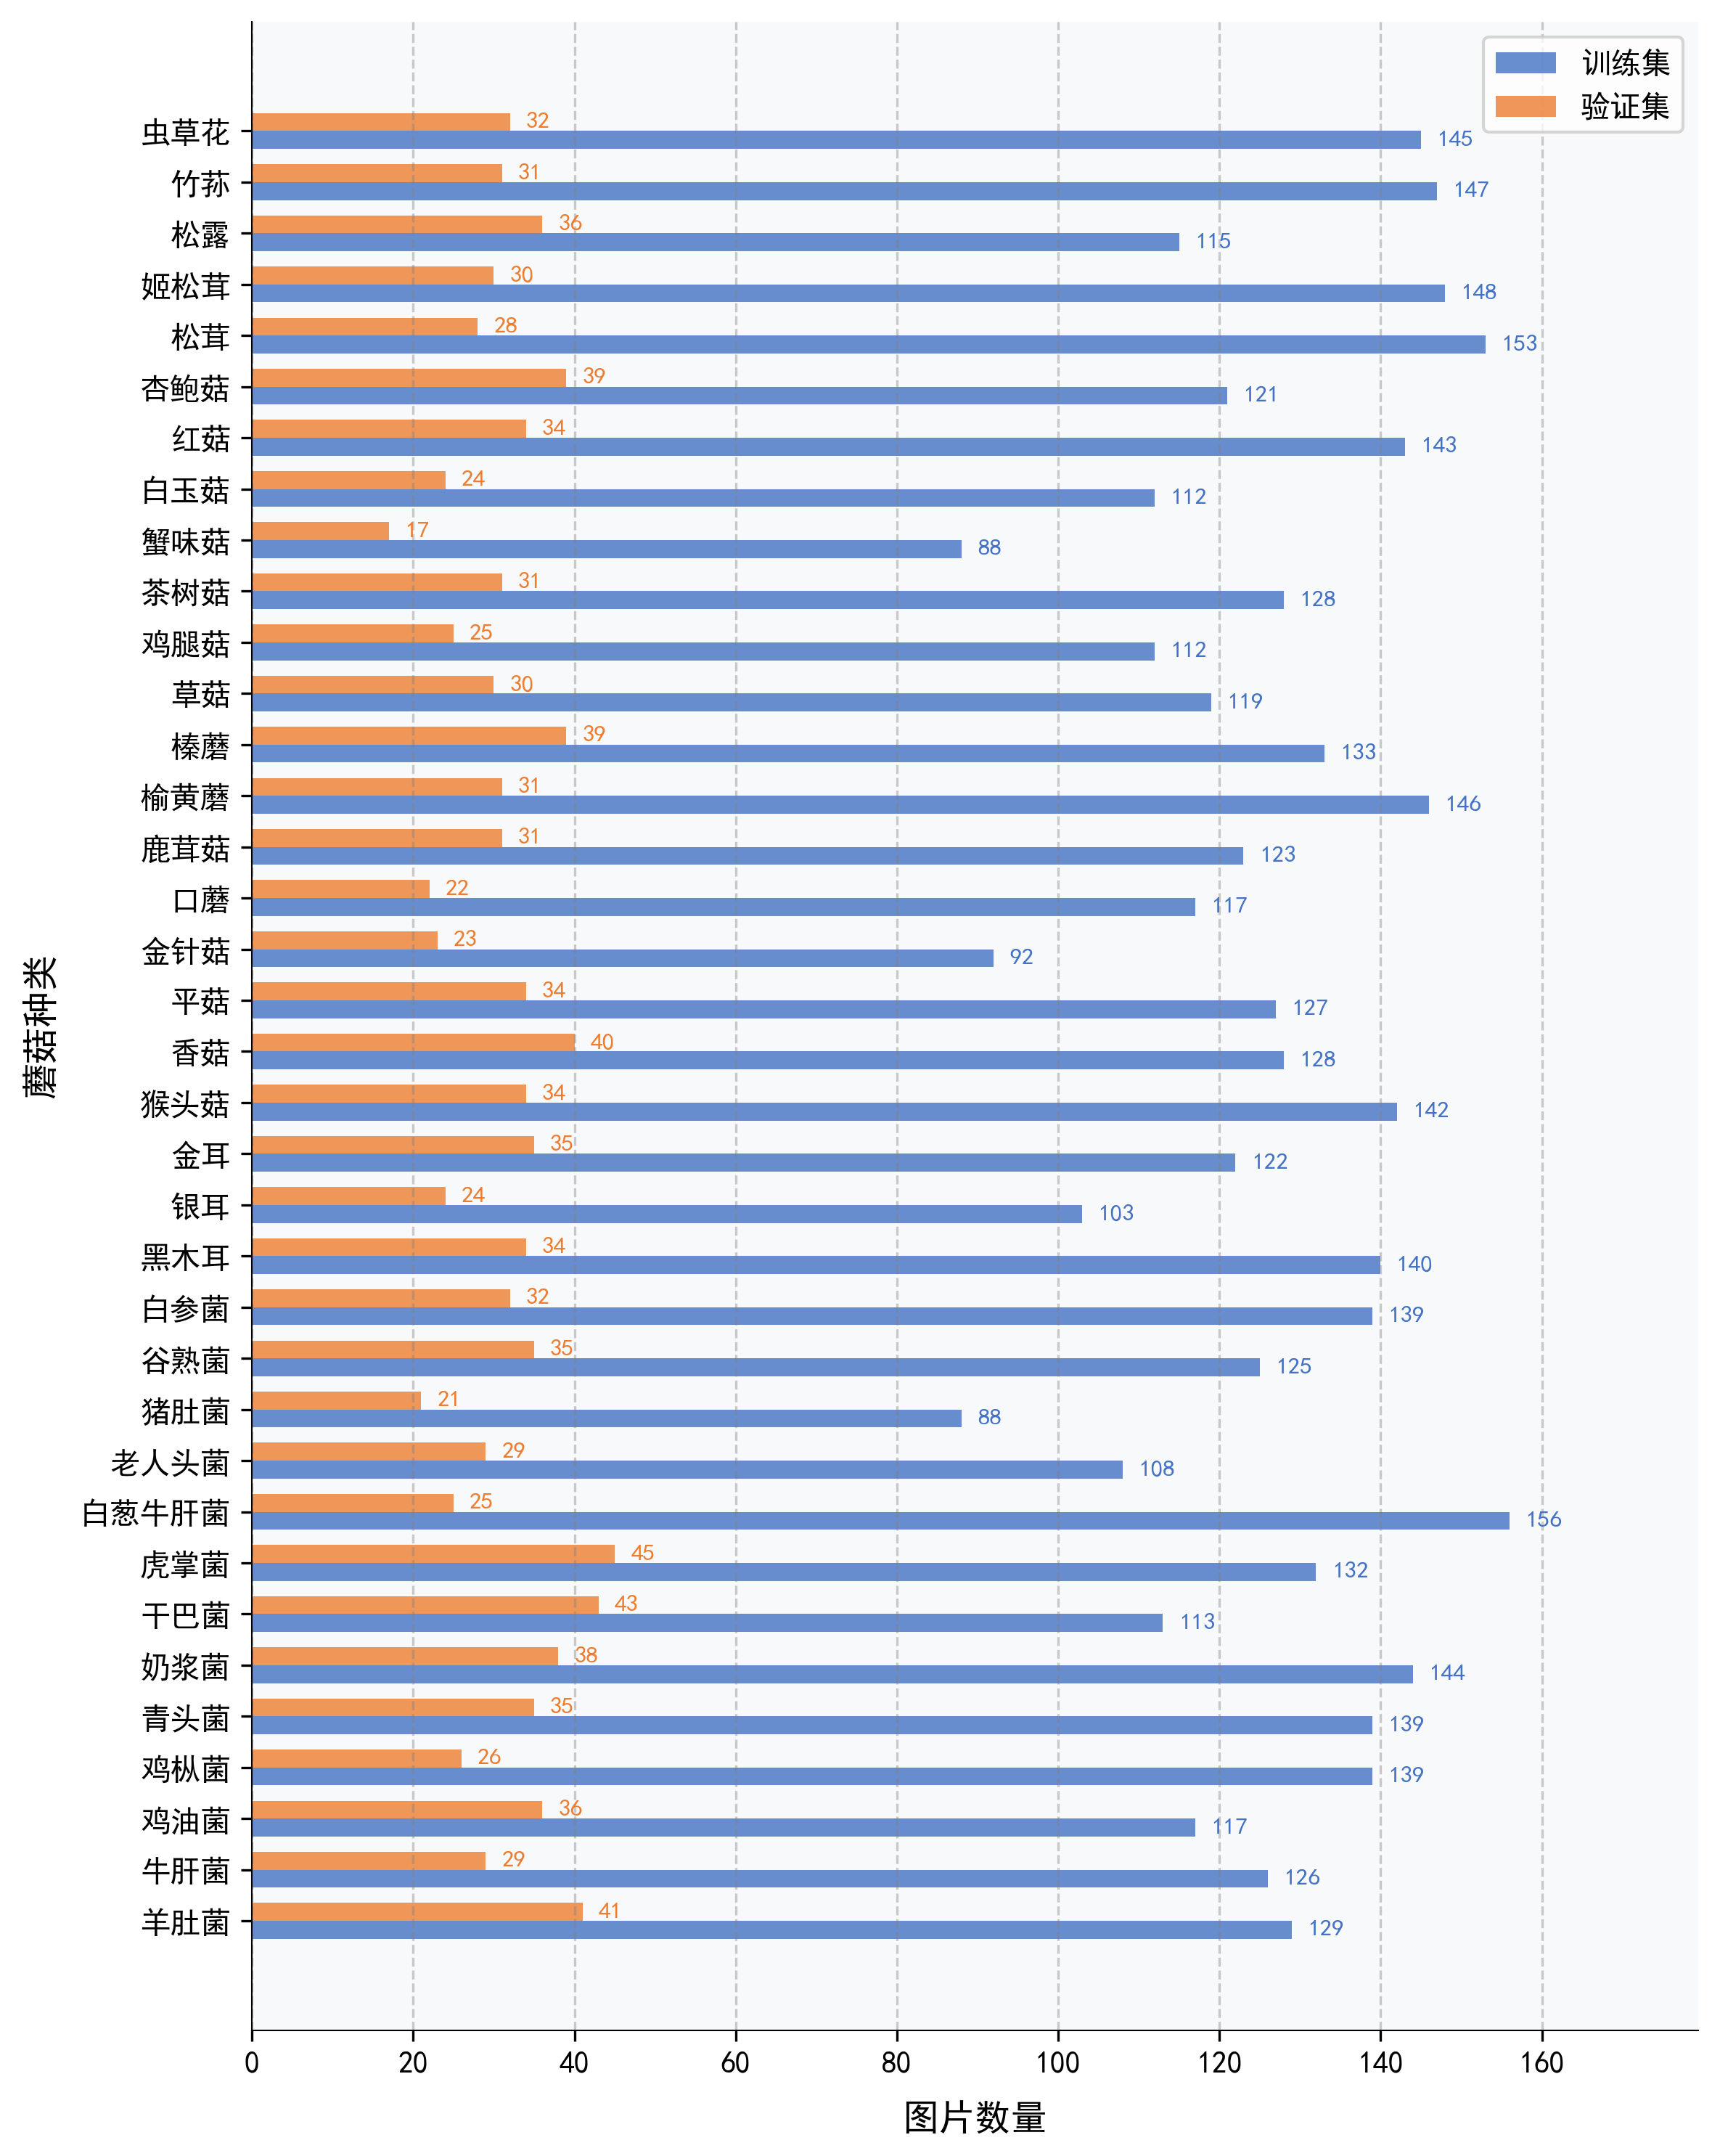

In [47]:
# 创建训练集和验证集类别分布的对比柱状图

# 准备数据
categories_names = list(train_category_counts.keys())  # 获取所有蘑菇种类名称
train_counts = [train_category_counts[name] for name in categories_names]  # 训练集中各类别数量
validation_counts = [validation_category_counts[name] for name in categories_names]  # 验证集中各类别数量

# 设置图形大小
plt.figure(figsize=(8, 10))

# 设置柱状图的位置
x = np.arange(len(categories_names))
width = 0.35  # 柱子的宽度

# 绘制训练集和验证集的柱状图
bars1 = plt.barh(x - width/2, train_counts, width, label='训练集', color='#4472C4', alpha=0.8)
bars2 = plt.barh(x + width/2, validation_counts, width, label='验证集', color='#ED7D31', alpha=0.8)

# 添加数值标签
for i, bar in enumerate(bars1):
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             va='center', ha='left', fontsize=8, color='#4472C4')

for i, bar in enumerate(bars2):
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             va='center', ha='left', fontsize=8, color='#ED7D31')

# 设置图表标题和轴标签
plt.xlabel('图片数量', fontsize=12, labelpad=8)
plt.ylabel('蘑菇种类', fontsize=12, labelpad=8)
plt.yticks(x, categories_names, fontsize=10)

# 添加图例
plt.legend(loc='upper right', fontsize=10)

# 设置坐标轴样式
plt.tick_params(axis='x', which='major', labelsize=10)
plt.xlim(0, max(max(train_counts), max(validation_counts)) * 1.15)  # 设置x轴范围，留出更多空间

# 添加网格线
plt.grid(axis='x', linestyle='--', alpha=0.4, color='gray')

# 添加背景色和边框样式
plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)

# 添加标题
#plt.title('训练集与验证集各类别图像数量对比', fontsize=14, pad=15)

# 自动调整布局
plt.tight_layout()

# 保存图表
plt.savefig('img/train_val_comparison.png',
            bbox_inches='tight',
            dpi=800,
            facecolor='#f8f9fa')

# 显示图形
plt.show()

# 8.按类别保存图片

In [39]:
# 创建保存图片的目录
train_img_dir = 'datasets/train_images'
val_img_dir = 'datasets/val_images'

# 确保目录存在
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)

# 初始化计数器
train_counters = {category: 0 for category in class_names}
val_counters = {category: 0 for category in class_names}

# 保存训练集图片
print("正在保存训练集图片...")
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        # 获取类别ID
        category_id = class_names[np.argmax(label.numpy())]
        # 创建类别目录
        category_dir = os.path.join(train_img_dir, category_id)
        os.makedirs(category_dir, exist_ok=True)
        # 保存图片
        img_path = os.path.join(category_dir, f'{train_counters[category_id]}.png')
        tf.keras.preprocessing.image.save_img(img_path, image.numpy())
        # 更新计数器
        train_counters[category_id] += 1

# 保存验证集图片
print("正在保存验证集图片...")
for images, labels in validation_dataset:
    for image, label in zip(images, labels):
        # 获取类别ID
        category_id = class_names[np.argmax(label.numpy())]
        # 创建类别目录
        category_dir = os.path.join(val_img_dir, category_id)
        os.makedirs(category_dir, exist_ok=True)
        # 保存图片
        img_path = os.path.join(category_dir, f'{val_counters[category_id]}.png')
        tf.keras.preprocessing.image.save_img(img_path, image.numpy())
        # 更新计数器
        val_counters[category_id] += 1

print("图片已按类别保存到datasets目录")

正在保存训练集图片...
正在保存验证集图片...
图片已按类别保存到datasets目录


# 9.显示数据集中的图像样本

class05
奶浆菌
class22
榆黄蘑
class28
白玉菇
class24
草菇


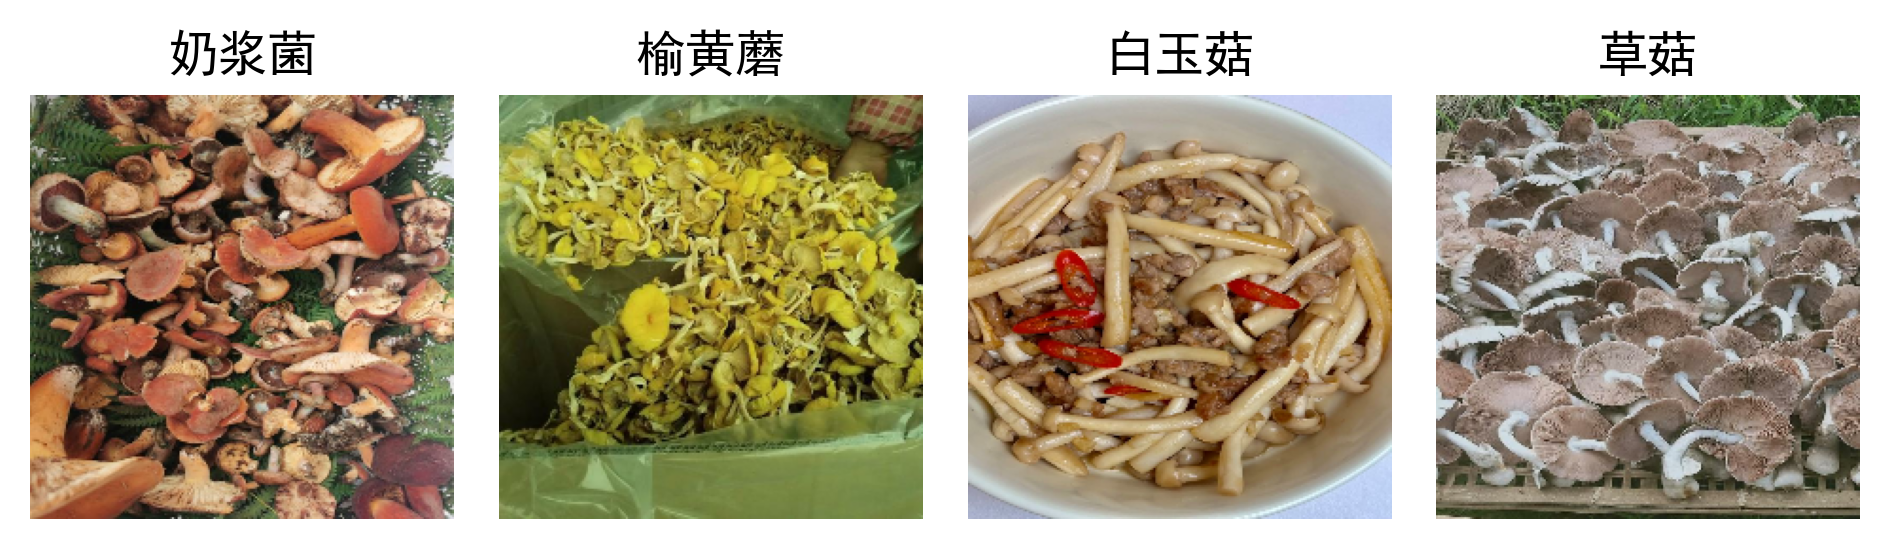

In [46]:
# 获取训练数据集中的类别名称
class_names = train_dataset.class_names

# 设置要在图中显示的随机样本图像数量
num_images_to_show = 4

# 初始化存储图像和标签的列表
images_to_display = []
labels_to_display = []

# 从训练数据集中随机抽取一批数据
for images, labels in train_dataset.take(1):
    indices = np.random.choice(range(images.shape[0]),
                             num_images_to_show,
                             replace=False)

    for index in indices:
        images_to_display.append(images[index])
        labels_to_display.append(labels[index])

# 创建子图网格
fig, axes = plt.subplots(1, num_images_to_show, figsize=(6.4, 4))

# 遍历显示每张图像
for i, (image, label) in enumerate(zip(images_to_display, labels_to_display)):
    ax = axes[i]
    ax.imshow(image.numpy().astype("uint8"))
    # 获取类别ID并转换为中文名称
    category_id = class_names[np.argmax(label.numpy())]
    category_name = categories[category_id]
    ax.set_title(category_name, fontsize=12)
    ax.axis("off")

# 自动调整子图之间的间距
plt.tight_layout()

# 保存图形
plt.savefig('img/mushroom_samples.png', dpi=800, bbox_inches='tight')

# 显示整个图形
plt.show()

# 10.压缩文件

In [48]:
# 复制label.txt到datasets文件夹
if os.path.exists(label_path):
    with open(label_path, 'r', encoding='utf-8') as src:
        with open('datasets/label.txt', 'w', encoding='utf-8') as dst:
            dst.write(src.read())
    print('label.txt已复制到datasets文件夹')
else:
    print('警告：label.txt文件不存在')

# 获取当前时间作为文件名的一部分
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 定义要压缩的文件夹和对应的压缩文件名
folders_to_zip = {
    'img': f'step2_return_img_{current_time}.zip',
    'csv': f'step2_return_csv_{current_time}.zip',
    'datasets': f'step2_return_datasets_{current_time}.zip'
}

# 压缩每个文件夹
for folder, zip_name in folders_to_zip.items():
    if os.path.exists(folder) and os.listdir(folder):  # 检查文件夹是否存在且不为空
        os.system(f'zip -r {zip_name} {folder}')
        print(f'压缩文件已创建：{zip_name}')
    else:
        print(f'警告：{folder}文件夹不存在或为空，跳过压缩')

label.txt已复制到datasets文件夹
压缩文件已创建：step2_return_img_20250517_053259.zip
压缩文件已创建：step2_return_csv_20250517_053259.zip
压缩文件已创建：step2_return_datasets_20250517_053259.zip
